# 🎬 Generating Movie Reviews with GPT Prompting

In this notebook, we dive into the world of **synthetic data generation** using **LLMs** — especially **GPT-style models** — to boost performance on low-resource NLP tasks.

We’ll explore how to generate **fake movie reviews** and evaluate whether these reviews can help us **improve classification performance** on the IMDb dataset. We'll follow the [Dino paper](https://arxiv.org/abs/2104.07540) from Schick and Schütze (2021) to generate the fake movie titles and reviews.

---

## 📚 What You’ll Learn

1. How to **train a baseline modernBERT classifier** on real IMDb reviews.
2. How to **generate thousands of fake movie titles and reviews** using prompting.
3. Whether training on synthetic data can **compete with or enhance** performance on real data.
4. Strategies to combine real and generated data for **better generalization**.

---

## 🧭 Table of Contents

| Step | Description |
|------|-------------|
| 1️⃣  | Train a baseline ModernBERT model on IMDb |
| 2️⃣  | Evaluate model performance |
| 3️⃣  | Generate ~2000 fake movie titles |
| 4️⃣  | Prompt GPT to create positive and negative reviews |
| 5️⃣  | Train a model using only the synthetic data |
| 6️⃣  | Evaluate performance on real IMDb test set |
| 7️⃣  | Combine real + synthetic data and retrain |
| ✅  | Final evaluation and conclusion |

---

## 🤖 Why This Matters

Large Language Models (LLMs) like GPT-3.5/4 are **powerful data generators**.  
Used carefully, they can:

- Help in **few-shot scenarios**
- Enrich training data for **low-resource domains**
- Provide **task-adapted supervision** without manual annotation

We’ll use them in a **realistic pipeline** and see what works — and what doesn’t.

---

## 🏋️ Step 1: Train a Baseline `ModernBERT` Model on IMDb

Let’s begin by building a **baseline sentiment classifier** using the [IMDb dataset](https://huggingface.co/datasets/imdb) and the **`ModernBERT` model** — a 2024 rethinking of BERT, designed to be **faster and better with long contexts**.

### 🧪 Dataset

We use:
- **10,000 training reviews** (out of 25,000)
- **2,000 testing reviews** (randomly sampled)

Why a subset?  
To **speed up experimentation** — especially important when generating multiple models later on.

---

### 🧰 Tokenization

We load the tokenizer associated with the **ModernBERT** model (`answerdotai/ModernBERT-base`) and apply it to the reviews:
- `max_length=512`: we truncate longer reviews.
- `padding="max_length"`: we pad all reviews to the same length, which is essential for batch processing.

---

### ⚙️ Training Setup

Here are the **key hyperparameters** we define:

| Hyperparameter         | Value       | Explanation |
|------------------------|-------------|-------------|
| `batch_size`           | 64          | Number of reviews processed at once. |
| `num_epochs`           | 10          | Full passes through the training data. |
| `grad_accumulation_steps` | 2        | Accumulate gradients across 2 batches before updating weights (helps with stability and memory). |
| `steps_per_epoch`      | Based on data size | Number of updates per epoch. |
| `max_length`           | 512         | Cap on token length for each review. |

We use the Hugging Face + PyTorch integration to turn tokenized datasets into PyTorch `torch.utils.data.Dataset` objects, ready for model training.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import  TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm.auto import tqdm

# Load IMDB dataset
dataset = load_dataset("imdb")

# Sample 10000 data points
train_sample_size = 10000
train_dataset = dataset["train"].shuffle(seed=42).select(range(train_sample_size))
test_dataset = dataset["test"].shuffle(seed=42).select(range(2000))

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base")

# Tokenize function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

# Tokenize datasets
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

# Rename label column to labels
tokenized_train = tokenized_train.rename_column("label", "labels")
tokenized_test = tokenized_test.rename_column("label", "labels")

# Set format to PyTorch
tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Function to compute metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    return {
        'accuracy': accuracy_score(labels, predictions),
        'precision': precision_score(labels, predictions),
        'recall': recall_score(labels, predictions),
        'f1': f1_score(labels, predictions)
    }

# Define training parameters

batch_size = 64
num_epochs = 10
grad_accumulation_steps = 2

2025-05-14 10:47:49.202630: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-14 10:47:49.215995: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747219669.241244   10957 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747219669.246156   10957 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747219669.258503   10957 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Now that we’ve prepared the datasets, let’s build our classifier using the **ModernBERT** architecture and train it to predict sentiment (positive or negative).

---

### 🏗️ Model Architecture

We load the pretrained **ModernBERT** model with a **sequence classification head**:

```python
AutoModelForSequenceClassification.from_pretrained("answerdotai/ModernBERT-base", num_labels=2)
````

This model:

* Uses pretrained transformer weights (from general language modeling).
* Adds a final classification layer to predict **2 labels**: `positive` or `negative`.

---

### ⚙️ Training Configuration

We define training settings via `TrainingArguments`. Key parameters:

| Argument                      | Value | Explanation                                                       |
| ----------------------------- | ----- | ----------------------------------------------------------------- |
| `num_train_epochs`            | 10    | Train for 10 full passes through the training data.               |
| `per_device_train_batch_size` | 64    | Batch size for training.                                          |
| `per_device_eval_batch_size`  | 64    | Batch size during evaluation.                                     |
| `learning_rate`               | 5e-5  | A common learning rate for transformer fine-tuning.               |
| `weight_decay`                | 0.01  | Helps prevent overfitting.                                        |
| `fp16=True`                   | Yes   | Enables faster training with mixed precision (if GPU allows).     |
| `gradient_accumulation_steps` | 2     | Gradients are averaged over 2 steps to simulate a larger batch.   |
| `eval_strategy="no"`          | –     | No intermediate validation during training (evaluate at the end). |

---

### 🏃 Training & Evaluation

We use the Hugging Face `Trainer` API to:

1. Initialize and train the model with `trainer.train()`.
2. Evaluate the model after training using `trainer.evaluate()`.

We return and print standard performance metrics:

* **Accuracy**
* **Precision**
* **Recall**
* **F1-score**

---

✅ This gives us our **baseline model**, trained on real IMDb reviews.
We’ll soon compare this against models trained on **synthetic data** or **hybrid datasets**.

In [2]:
import torch
# Function to train model
def train_model(train_dataset, eval_dataset, num_epochs=10, run_num=0, sample_size=0):
    # Load model with memory optimization
    model = AutoModelForSequenceClassification.from_pretrained(
        "answerdotai/ModernBERT-base", 
        num_labels=2
    )
    
    # Define training arguments with smaller batch size for large samples
    actual_batch_size = batch_size
    if sample_size > 500:
        actual_batch_size = batch_size // 2  # Reduce batch size for larger datasets
    
    # Define training arguments
    training_args = TrainingArguments(
        output_dir=f"./results/run{run_num}_size{sample_size}",
        num_train_epochs=num_epochs,
        per_device_train_batch_size=actual_batch_size,
        per_device_eval_batch_size=actual_batch_size,
        weight_decay=0.01,
        learning_rate=5e-5,
        eval_strategy="no",  # we just want to evaluate at the end
        save_strategy="no",
        load_best_model_at_end=False,
        push_to_hub=False,
        fp16=True,
        gradient_accumulation_steps=grad_accumulation_steps,
        optim="adamw_torch",
        dataloader_num_workers=0,
        report_to="none",
        logging_steps=500
    )
    
    # Create trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics,
    )
    
    # Train model
    trainer.train()
    
    # Evaluate model
    metrics = trainer.evaluate()
    
    # Save model only at the end
    save_path = f"./models/modernbert_run{run_num}_size{sample_size}"
    trainer.save_model(save_path)
    print(f"Model saved to {save_path}")
    
    # Clear memory
    del trainer
    torch.cuda.empty_cache()
    
    return {
        'accuracy': metrics['eval_accuracy'],
        'precision': metrics['eval_precision'],
        'recall': metrics['eval_recall'],
        'f1': metrics['eval_f1']
    }, save_path

To evaluate how **ModernBERT** performs with different amounts of training data, we run a **learning curve experiment**.

### 🧪 Experimental Setup

We train the model on progressively larger subsets of the IMDb training set:
- Sample sizes: **10, 100, 250, 500, 1000** examples.
- We repeat each training size for **3 different random seeds** to estimate variability.

At each step, we:
1. Sample a subset of the data with a unique seed.
2. Tokenize and format it for training.
3. Train the model and evaluate it on the same test set.
4. Store evaluation metrics: **accuracy**, **precision**, **recall**, and **F1-score**.

### 📊 What We Get

After all runs:
- We compute the **mean** and **standard deviation** of each metric for every training size.
- This helps us understand:
  - How performance scales with data.
  - How stable/robust results are across random splits.

This is especially useful when deciding whether **synthetic data generation** is worth pursuing — and how much real data you actually need to achieve reasonable accuracy.

In [3]:
sample_sizes = [10, 100, 250, 500, 1000]
num_runs = 3
all_metrics = {size: [] for size in sample_sizes}
all_model_paths = {size: [] for size in sample_sizes}

# Create directory for models if it doesn't exist
import os
os.makedirs("./models", exist_ok=True)

for run in range(num_runs):
    print(f"\nRun {run+1}/{num_runs}")
    
    for size in sample_sizes:
        print(f"Training with {size} samples...")
        # Sample subset with different seed for each run
        run_seed = 42 + run
        train_subset = train_dataset.shuffle(seed=run_seed).select(range(size))
        tokenized_subset = train_subset.map(tokenize_function, batched=True)
        tokenized_subset = tokenized_subset.rename_column("label", "labels")
        tokenized_subset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
        
        # Clear memory before training
        torch.cuda.empty_cache()
        
        metrics, model_path = train_model(tokenized_subset, tokenized_test, run_num=run+1, sample_size=size)
        all_metrics[size].append(metrics)
        all_model_paths[size].append(model_path)

# Calculate mean and standard deviation
mean_metrics = {}
std_metrics = {}

for size in sample_sizes:
    # Extract metrics for this size across all runs
    size_metrics = all_metrics[size]
    
    # Calculate mean for each metric
    mean_metrics[size] = {
        metric: np.mean([run[metric] for run in size_metrics]) 
        for metric in size_metrics[0].keys()
    }
    
    # Calculate std for each metric
    std_metrics[size] = {
        metric: np.std([run[metric] for run in size_metrics])
        for metric in size_metrics[0].keys()
    }

# Add sample size 0 with metrics of 0
sample_sizes_with_zero = [0] + sample_sizes
mean_metrics[0] = {metric: 0.0 for metric in mean_metrics[sample_sizes[0]].keys()}
std_metrics[0] = {metric: 0.0 for metric in std_metrics[sample_sizes[0]].keys()}

# Create DataFrames
mean_df = pd.DataFrame([mean_metrics[size] for size in sample_sizes], index=sample_sizes)
std_df = pd.DataFrame([std_metrics[size] for size in sample_sizes], index=sample_sizes)

# Create updated DataFrames including the zero point
mean_df_with_zero = pd.DataFrame([mean_metrics[size] for size in sample_sizes_with_zero], index=sample_sizes_with_zero)
std_df_with_zero = pd.DataFrame([std_metrics[size] for size in sample_sizes_with_zero], index=sample_sizes_with_zero)

print("\nMean metrics:")
print(mean_df)
print("\nStandard deviation:")
print(std_df)


Run 1/3
Training with 10 samples...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Model saved to ./models/modernbert_run1_size10
Training with 100 samples...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Model saved to ./models/modernbert_run1_size100


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training with 250 samples...


Step,Training Loss


Model saved to ./models/modernbert_run1_size250


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training with 500 samples...


Step,Training Loss


Model saved to ./models/modernbert_run1_size500
Training with 1000 samples...


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Model saved to ./models/modernbert_run1_size1000

Run 2/3
Training with 10 samples...


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Model saved to ./models/modernbert_run2_size10
Training with 100 samples...


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Model saved to ./models/modernbert_run2_size100
Training with 250 samples...


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Model saved to ./models/modernbert_run2_size250
Training with 500 samples...


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Model saved to ./models/modernbert_run2_size500
Training with 1000 samples...


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Model saved to ./models/modernbert_run2_size1000

Run 3/3
Training with 10 samples...


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Model saved to ./models/modernbert_run3_size10
Training with 100 samples...


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Model saved to ./models/modernbert_run3_size100
Training with 250 samples...


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Model saved to ./models/modernbert_run3_size250
Training with 500 samples...


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Model saved to ./models/modernbert_run3_size500
Training with 1000 samples...


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Model saved to ./models/modernbert_run3_size1000

Mean metrics:
      accuracy  precision    recall        f1
10    0.537667   0.635001  0.392000  0.360452
100   0.584333   0.778339  0.346000  0.381199
250   0.845000   0.845223  0.845667  0.844775
500   0.916000   0.903116  0.932667  0.917327
1000  0.928500   0.921158  0.937667  0.929084

Standard deviation:
      accuracy  precision    recall        f1
10    0.026285   0.112866  0.366389  0.254926
100   0.043613   0.128041  0.299150  0.219501
250   0.012457   0.015996  0.037277  0.015319
500   0.002160   0.014415  0.020418  0.003226
1000  0.003742   0.011496  0.019703  0.004692


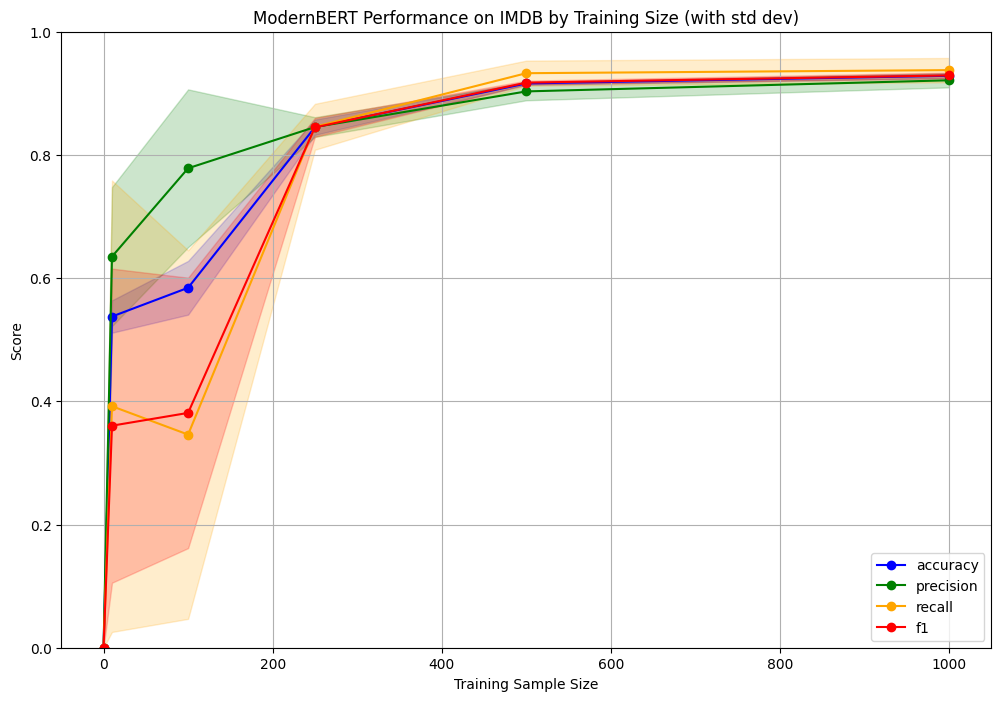

In [5]:
# Add sample size 0 with metrics of 0
sample_sizes_with_zero = [0] + sample_sizes
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    mean_metrics[0] = {metric: 0.0 for metric in mean_metrics[sample_sizes[0]].keys()}
    std_metrics[0] = {metric: 0.0 for metric in std_metrics[sample_sizes[0]].keys()}

# Create updated DataFrames including the zero point
mean_df_with_zero = pd.DataFrame([mean_metrics[size] for size in sample_sizes_with_zero], index=sample_sizes_with_zero)
std_df_with_zero = pd.DataFrame([std_metrics[size] for size in sample_sizes_with_zero], index=sample_sizes_with_zero)

# Plot with fill_between for error bands
plt.figure(figsize=(12, 8))
colors = ['blue', 'green', 'orange', 'red']

for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1']):
    # Get mean and std values
    means = mean_df_with_zero[metric].values
    stds = std_df_with_zero[metric].values
    
    # Plot the mean line
    plt.plot(sample_sizes_with_zero, means, marker='o', color=colors[i], label=metric)
    
    # Add the error band
    plt.fill_between(
        sample_sizes_with_zero, 
        np.maximum(0, means - stds),  # Ensure lower bound isn't negative
        np.minimum(1, means + stds),  # Ensure upper bound isn't above 1
        color=colors[i], 
        alpha=0.2
    )

plt.xlabel('Training Sample Size')
plt.ylabel('Score')
plt.title('ModernBERT Performance on IMDB by Training Size (with std dev)')
plt.legend()
plt.grid(True)
plt.ylim(0, 1.0)

plt.show()

### 🔍 Key Insights

1. **Rapid Performance Growth**:
   - With only **10 labeled examples**, F1 is low: **36%** (as expected).
   - But with just **250 examples**, we reach an impressive **85% F1** — showing the power of **transfer learning** from pretrained BERT-like models.

2. **Diminishing Returns**:
   - From **250 → 500**, F1 improves further to **~91%**, and beyond that, gains start to **flatten**.
   - The **standard deviation also drops**, indicating increasing **stability** as we scale.

3. **Outperforms Traditional Models**:
   - Even with **500 examples**, we beat the **Logistic Regression + TF-IDF** baseline trained on the full 25k set (≈88% F1 in previous notebooks).

4. **Implication**:
   - We don’t need 25,000 labeled examples to reach strong performance.
   - This motivates our next step: can we **generate synthetic data** to boost a small real dataset?

--- 

## 🎭 Generating Synthetic Movie Reviews with GPT

We now shift gears and explore **synthetic data generation** — using a large language model (**GPT-4o-mini**) to help us **simulate movie reviews**.

### 🧩 Why Are We Doing This?

1. **Manual Labeling is Expensive**:
   - In the previous step, we saw that with just **250 real examples**, we get decent results.
   - Annotating 250 reviews manually is possible — but time-consuming and hard to scale.

2. **LLMs Have Seen a Lot**:
   - GPT models (especially GPT-4-class) have likely been exposed to thousands of movie reviews.
   - They’ve learned review structure, tone, and **patterns associated with sentiment** (both positive and negative).

3. **Let’s Use That Knowledge**:
   - Instead of asking humans to write 1000 reviews, we:
     - First generate around **1000 fake movie titles** (e.g., “The Final Horizon”, “Quantum Heist”).
     - Then, for each title:
       - Generate a **positive review**.
       - Generate a **negative review**.

This gives us a synthetic dataset of **2000 labeled reviews** — balanced, diverse, and fast to generate.

### 🔐 Setup Note

Make sure your OpenAI API key is available via:

* A `.env` file with `OPENAI_API_KEY=sk-...`
* Or set it directly in your Python environment.

---

### 📽️ Generate Fake Movie Titles with GPT-4o-mini

In this step, we use **GPT-4o-mini** to come up with **1000 realistic-sounding movie titles** across a variety of genres.

#### ⚙️ How It Works:

* We send a prompt like:

  > “Generate 20 unique, creative and plausible movie titles.”
* We ask for **diverse genres** (e.g., sci-fi, drama, horror, romance) to cover a wide stylistic range.
* This is done in **batches** (e.g., 20 at a time) to avoid API rate limits and ensure manageable output size.
* The model responds with a list of raw titles, which we clean and store.

This gives us a synthetic **universe of fake movies** to use in the next step.

In [41]:
import litellm
import pandas as pd
import random
from tqdm.auto import tqdm
import asyncio

async def generate_movie_titles_parallel(n=1000, max_concurrent=5):
    titles = []
    semaphore = asyncio.Semaphore(max_concurrent)
    
    async def generate_batch(batch_size):
        async with semaphore:
            prompt = """
                    Generate {batch_size} unique, creative and plausible movie titles, description and main guest stars.
                    Include a mix of genres (action, comedy, drama, sci-fi, horror, romance, thriller, etc.).
                    Vary the length of the titles and descriptions. And invent main guest stars.
                    Make them diverse and interesting. Only output the titles, descriptions and main guest stars, one per line without numbering, nothing else.
                    
                    Output Format:
                    Title1 - Description1 - Main Guest Stars1
                    Title2 - Description2 - Main Guest Stars2
                    ...
                    Title{batch_size} - Description{batch_size} - Main Guest Stars{batch_size}
                    """
            
            try:
                response = await litellm.acompletion(
                    model="gpt-4o-mini",
                    messages=[{"role": "user", "content": prompt.format(batch_size=batch_size)}],
                    temperature=0.9,
                    max_tokens=500
                )
                
                batch_titles = response.choices[0].message.content.strip().split('\n')
                return [t.strip() for t in batch_titles if t.strip()]
            except Exception as e:
                print(f"Error generating titles: {e}")
                # Wait a bit before retrying
                await asyncio.sleep(2)
                return []
    
    # Calculate number of batches
    batch_size = 20
    num_batches = n // batch_size + (1 if n % batch_size > 0 else 0)
    
    # Create tasks
    tasks = []
    for i in range(num_batches):
        # For the last batch, adjust batch size if needed
        current_batch_size = min(batch_size, n - i * batch_size)
        if current_batch_size > 0:
            tasks.append(generate_batch(current_batch_size))
    
    # Run tasks concurrently
    print(f"Generating {n} titles with {num_batches} batches using {max_concurrent} concurrent requests...")
    results = await asyncio.gather(*tasks)
    
    # Flatten results
    for batch_titles in results:
        titles.extend(batch_titles)
    
    # Ensure we have exactly n titles
    return titles[:n]

In [45]:
# 1. Generate 1000 movie titles
print("Generating 1000 movie titles...")
movie_titles = await generate_movie_titles_parallel(1000, max_concurrent=20)
    
# 2. Show some examples of the titles
print("\nSample of generated movie titles:")
for i, title in enumerate(random.sample(movie_titles, 10)):
    print(f"{i+1}. {title}")

Generating 1000 movie titles...
Generating 1000 titles with 50 batches using 20 concurrent requests...

Sample of generated movie titles:
1. Quantum Shift - When a scientist accidentally opens a portal to parallel universes, she grapples with alternate versions of herself as each reality poses a new threat to her existence. - Priya Kapoor, Samir Tanaka
2. Eclipsed Love - A blind musician and a talented painter find love while navigating their respective insecurities amidst a celestial event that changes their lives forever. - Naomi Reyes, Samir Khan
3. Cursed Reflections - A horror film about a family that moves into an old mansion only to discover that their mirror holds the souls of previous inhabitants, leading to terrifying hauntings. - Lila Arnett, Jamal Cross
4. Quantum Heartbreak - A brilliant quantum physicist invents a time-traveling device to mend her broken heart, but her meddling with time creates unexpected romantic entanglements and challenges. - Lila Tran, Jason Brooks, 

### ✍️ Generate Synthetic Reviews (Positive + Negative)

Once we have fake movie titles, we generate **two reviews per title**:

* One **positive** (e.g., "Absolutely loved the cinematography!")
* One **negative** (e.g., "The plot was slow and predictable.")

#### 🧠 Prompting Strategy:

* We provide GPT-4o-mini with:

  * The **movie title**, description and main guest stars.
  * A short instruction to make the review sound human and emotional.
  * A word count suggestion (150–200 words).

#### ✅ Why This Works:

* GPT-4o-mini has been trained on massive corpora of reviews and human opinions — it's excellent at **mimicking tone, style, and sentiment**.
* This technique allows us to **instantly build a large labeled dataset**, simulating real-world reviews at scale.

Once generated, we’ll have a dataset with \~2000 reviews (1000 positive and 1000 negative), all tied to realistic but **synthetically created content**.

In [56]:
import litellm
import pandas as pd
import random
import asyncio
import time
from tqdm.auto import tqdm

# Function to generate reviews in parallel
async def generate_reviews_parallel(titles, max_concurrent=5):
    reviews = []
    semaphore = asyncio.Semaphore(max_concurrent)
    
    async def generate_review_pair(title):
        async with semaphore:
            # Generate positive review
            pos_prompt = f"""You are a movie critic and you need to make an inedit positive review. Write a positive movie review for:
            "{title}"
            You liked the movie and you are going to write a review about it. Everyone knows the movie title you're going to review, therefore do not mention it in the review. Focus on the plot, the acting, the music, the direction, the special effects, etc.
            Keep it between 150-200 words.
            
            Here are examples of positive reviews you should get inspired by:

            Title:
            The King of Masks - An aging street performer seeks a male heir to pass on his secret art of mask-changing but forms an unexpected bond with a spirited young girl. - Zhu Xu, Zhou Renying, Zhang Zhigang.
            Review:
            One of the most heart-warming foreign films I've ever seen.<br /><br />The young girl is an amazing talent. Stellar performances by her (Doggie), the old man (the king of masks), and Liang (the Living Boddhisatva).<br /><br />(SPOILER) The deplorable treatment of children, especially females is disturbing.<br /><br />Loved the music. The original Chinese dialog heightens the emotional intensity of the performances and the story.<br /><br />This is a MUST SEE -- enjoyable family film, although not for very young children. Would have rated the DVD release even higher if the soundtrack had been transferred better onto the DVD and the transfer had included the widescreen version.
            ---
            Title:
            Men in White - Two bumbling janitors become Earth’s last hope when they accidentally get recruited to stop an alien invasion. - Tom Wright, Doug E. Doug, Nathan Anderson.
            Review:
            What is with all of the European (especially England) comments here? All i gotta say is that when i saw this movie for the first time when i was like 13 i thought it was great. Of course it\'s stupid. That\'s the point. You have to see the movie Dr. Strangelove and Men in Black to get the whole joke behind this movie, but come on people, what did you expect to see? I can think of many movies that are far worse than this, and they were expensive Hollwood films with real actors in them. For what it\'s worth, Men in White is a very stupid-funny mock of a movie. And with all the stupid-funny stuff that England has been making for the last half century, i am shocked at all the negative comments. Us stupid Americans like our stupid humor. P.S., see \'Team America: World Police" for some true laughs that Europeans will especially like. HA!
            ---
            Title:
            The Stone Boy -  After a tragic accident, a young boy’s silence deepens the emotional rift in a grieving rural family. - Robert Duvall, Glenn Close, Jason Presson.
            Review:
            I had seen this film way back in the 80's and had nearly forgotten it when I noticed it was on tv again and watched it. I remembered having liked this little sleeper when I first saw it, and I liked it even better on second viewing.<br /><br />All of the actors, especially Robert Duvall, Glenn Close, Wilfred Brimley, Frederic Forrest, and Jason Presson (as the twelve-year-old boy who feels responsible for the accidental shooting death of his older brother), are superb. The film has a very genuine feel to it--an understated, quiet, deeply moving story of a family aching with grief. The dialogue is sparse but telling, and the nonverbal acting is outstanding. Sort of like a simpler, rural version of Ordinary People sans psychiatrist but equally impressive family dynamics.<br /><br />The Stone Boy is well worth the time and emotional energy involved in watching it.

            Title:
            {title}
            Review:
            """
            
            # Generate negative review
            neg_prompt = f"""You are a movie critic. You need to make an inedit negative review. Write a negative movie review for:
            "{title}"
            You disliked the movie and you are going to write a review about it. Everyone knows the movie title you're going to review, therefore do not mention it in the review. Focus on the plot, the acting, the music, the direction, the special effects, etc.
            Keep it between 150-200 words.
            
            Here are examples of negative reviews you should get inspired by:

            Title:
            Cat Among the Pigeons - Hercule Poirot investigates a murder tied to a prestigious girls' school, uncovering secrets buried beneath elegance and espionage -David Suchet, Harriet Walter, Raji James.
            Review:
            The original book of this was set in the 1950s but that won't do for the TV series because most people watch for the 1930s style. Ironically the tube train near the end was a 1950s train painted to look like a 1930s train so the Underground can play at that game too. Hanging the storyline on a plot about the Jarrow March was feeble but the 50s version had students who were beginning to think about the world around them so I suppose making them think about the poverty of the marchers is much the same thing. All the stuff about Japp having to cater for himself was weak too but they had to put something in to fill the time. This would have made a decent half hour show or they could have filmed the book and made it a better long show. It is obvious this episode is a victim of style over content.
            ---
            Title:
            The Piano Teacher - A repressed piano teacher’s disturbing private desires unravel when she enters into a twisted relationship with a younger student. - Isabelle Huppert, Benoît Magimel, Mathieu Amalric.
            Review:
            Although I can see the potentially redeeming qualities in this film by way of it\'s intrigue, I most certainly thought that the painfully long nature in the way the scene structure played out was too much to ask of most viewers. Enormous holes in the screenplay such as the never explained "your father died today" comment by the mother made it even harder to try to make sense of these characters.<br /><br />This won first place at Cannes in 2001 which is a shock considering. Perhaps the French had been starved for film noir that year and were desperate for something as sadistic as this film. I understood the long scenes as a device to keep the viewer as uncomfortable as possible but when matched with the inability to relate to the main character it went too far for me and kept me at arms distance from the story altogether.<br /><br />This is a film for only the most dedicated fan of film noir and one who expects no gratification from having watched a film once it\'s over. I LOVED movies such as "Trainspotting" or "Requiem for a Dream" - which were far more disturbing but at least gave the viewer something in the way of editing and pacing. To watch this teachers slow and painful silence scene after scene just became so redundant that I found it tedious - and I really wanted to like this film at every turn.
            ---
            Title:
            There Will Be Blood - A ruthless oilman’s ambition drives him to wealth and madness in early 20th-century California. - Daniel Day-Lewis, Paul Dano, Ciarán Hinds.
            Review:
            I was utterly disappointed by this movie. I had read some of the other reviews here and had much higher expectations. I expected a drama with more intense character development. But that never happens in the movie. Daniel-Day Lewis is a good actor, but not as good as some reviewers here would have us believe. I tought he repeated the same set of 4 or 5 movements in the movie. I would rate his performance 6 out of 10.<br /><br />Acting: 6 out of 10 Direction is 5 out of 10. Script is the worst: 2 out of 10. <br /><br />I deleted the movie from my DVR at 70 mins. into the movie. Much better movies out there than this...

            Title:
            {title}
            Review:
            """
            
            try:
                # Run both requests concurrently
                pos_future = asyncio.ensure_future(async_completion(pos_prompt))
                neg_future = asyncio.ensure_future(async_completion(neg_prompt))
                
                # Wait for both to complete
                pos_response, neg_response = await asyncio.gather(pos_future, neg_future)
                
                return {
                    "title": title,
                    "positive_review": pos_response,
                    "negative_review": neg_response
                }
            except Exception as e:
                print(f"Error generating reviews for '{title}': {e}")
                await asyncio.sleep(2)
                return None
    
    async def async_completion(prompt):
        try:
            response = await litellm.acompletion(
                model="gpt-4o-mini",
                messages=[{"role": "user", "content": prompt}],
                temperature=0.9,
                max_tokens=400
            )
            return response.choices[0].message.content.strip()
        except Exception as e:
            print(f"API error: {e}")
            await asyncio.sleep(2)
            return "Error generating review."
    
    # Create tasks
    tasks = [generate_review_pair(title) for title in titles]
    
    # Run tasks concurrently
    print(f"Generating reviews for {len(titles)} titles using {max_concurrent} concurrent requests...")
    results = await asyncio.gather(*tasks)
    
    # Filter out None results (from errors)
    reviews = [r for r in results if r is not None]
    
    return reviews

In [58]:
# Generate reviews for a sample of titles in parallel
review_start_time = time.time()
print("\nGenerating sample reviews...")
sample_reviews = await generate_reviews_parallel(movie_titles, max_concurrent=20)

print(f"\nGenerated {len(sample_reviews)} reviews in {time.time() - review_start_time:.2f} seconds")

# Display the reviews
print("\nSample reviews:")
for i, review_data in enumerate(sample_reviews):
    print(f"\n{'-'*80}")
    print(f"Movie: {review_data['title']}")
    print(f"\nPOSITIVE REVIEW:")
    print(review_data['positive_review'])
    print(f"\nNEGATIVE REVIEW:")
    print(review_data['negative_review'])
    print(f"{'-'*80}")


Generating sample reviews...
Generating reviews for 553 titles using 20 concurrent requests...


/usr/lib/python3.10/selectors.py:75: RuntimeWarning: coroutine 'generate_movie_titles_parallel' was never awaited
  raise KeyError("{!r} is not registered".format(fileobj)) from None



Generated 553 reviews in 133.69 seconds

Sample reviews:

--------------------------------------------------------------------------------
Movie: Fractured Echoes - In a near-future world where sound can be weaponized, a deaf ex-soldier must navigate a treacherous underground war. - Zara Kwon, Malik Redd, Emma Li

POSITIVE REVIEW:
In this thrilling near-future narrative, we are plunged into a world where sound becomes both a weapon and a lifeline. The film takes us on an electrifying journey alongside a deaf ex-soldier, played with remarkable depth by Zara Kwon. Her portrayal is both powerful and nuanced, capturing the character's struggle and resilience amid chaos.

The direction is masterful, seamlessly blending heart-pounding action with moments of profound introspection. Malik Redd and Emma Li provide stellar performances that enrich the story, showcasing the silent yet impactful dynamics of their characters as they navigate a treacherous underground war. 

The sound design is par

In [59]:
# Save all data to CSV files
titles_df = pd.DataFrame({"title": movie_titles})
titles_df.to_csv("generated_movie_titles.csv", index=False)

reviews_df = pd.DataFrame(sample_reviews)
reviews_df.to_csv("generated_movie_reviews.csv", index=False)

print("\nAll data saved to CSV files.")


All data saved to CSV files.


### 🧪 From Synthetic Data to Model Fine-Tuning

We’ve now generated a rich set of **synthetic reviews**, each one tied to a fake yet plausible **movie title** and written in either a **strongly positive** or **strongly negative** tone.

Let’s quickly recap what we observe from these examples:

---

#### 🎬 Example: *The Last Stop*

> A time-travel thriller balancing emotional introspection and action.

* ✅ The **positive review** is nuanced, emotional, and structured like a professional critique.
* ❌ The **negative review** feels harsh and critical, following recognizable negative sentiment cues.

---

#### 🎵 Example: *The Sound of Shadows*

> A deaf musician in conflict with a crime syndicate.

* ✅ The **positive review** emphasizes artistry and resilience.
* ❌ The **negative review** deconstructs the film’s weaknesses, using common critical vocabulary.

---

### 🧠 What Does This Tell Us?

* These reviews **mirror real-world text structure** and use sentiment-loaded patterns that can help a model distinguish positive vs. negative tone.
* However, they’re **synthetic** — so the real test is whether they can help improve our model performance. Especially they look to have similar patterns in the way they have been generated. Maybe the prompt should be improved to make them more diverse.

---

### 🚀 Fine-Tuning with Synthetic Boost

To test the value of these reviews, we’ll:

1. Start from a **baseline model trained on 250 real examples** (from the IMDb dataset).
2. Incrementally add synthetic reviews:
   * +25 positive and +25 negative at each step.
3. Observe how performance evolves (accuracy, precision, recall, F1).
4. See whether this additional GPT-generated data can **boost generalization** and outperform the purely real-data baseline.

This mimics a realistic scenario where we:

* Have limited labeled data.
* Use **LLMs to bootstrap** a richer training set.

Let’s get to it.


In [3]:
def load_synthetic_data():
    reviews_df = pd.read_csv("generated_movie_reviews.csv")
    
    # Create separate entries for positive and negative reviews
    positive_reviews = [
        {"text": row["positive_review"], "label": 1} 
        for _, row in reviews_df.iterrows()
    ]
    
    negative_reviews = [
        {"text": row["negative_review"], "label": 0} 
        for _, row in reviews_df.iterrows()
    ]
    
    return  positive_reviews, negative_reviews

In [11]:
from datasets import Dataset

# Load synthetic data
positive_reviews, negative_reviews = load_synthetic_data()

# Define the experiment configurations
base_size = 250  # Starting with 250 real samples
synthetic_increment = 50  # Adding 50 synthetic samples (25 pos + 25 neg) at each step
max_synthetic = 500  # Maximum 250 synthetic samples to reach 500 total
num_runs = 3

run_results = []
all_results = []

print(f"Training baseline with {base_size} real samples...")

train_subset = train_dataset.shuffle(seed=42).select(range(base_size))
tokenized_real = train_subset.map(tokenize_function, batched=True)
tokenized_real = tokenized_real.rename_column("label", "labels")
tokenized_real.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

baseline_metrics, model_path = train_model(tokenized_real, tokenized_test)
run_results.append({
        "real_samples": base_size,
        "synthetic_samples": 0,
        "total_samples": base_size,
        **baseline_metrics
    })

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training baseline with 250 real samples...


Step,Training Loss


Model saved to ./models/modernbert_run0_size0


In [12]:
for run in range(num_runs):
    print(f"\n=== Run {run+1}/{num_runs} ===")
    run_seed = 42 + run
    np.random.seed(run_seed)
    for i in range(1, (max_synthetic // synthetic_increment) + 1):
        num_synthetic = i * synthetic_increment
        print(f"Training with {base_size} real + {num_synthetic} synthetic samples...")
        
        # Select synthetic samples for this configuration
        # Ensure equal numbers of positive and negative
        half_synth = num_synthetic // 2
        positive_subset = np.random.choice(positive_reviews, half_synth)
        negative_subset = np.random.choice(negative_reviews, half_synth)
        
        # Create a combined dataset
        combined_data = {
            "text": train_subset["text"] + [item["text"] for item in positive_subset] + [item["text"] for item in negative_subset],
            "label": train_subset["label"] + [item["label"] for item in positive_subset] + [item["label"] for item in negative_subset]
        }
        
        # Convert to HF Dataset
        combined_dataset = Dataset.from_dict(combined_data)
        
        # Tokenize and format
        tokenized_combined = combined_dataset.map(tokenize_function, batched=True)
        tokenized_combined = tokenized_combined.rename_column("label", "labels")
        tokenized_combined.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
        
        # Train and evaluate
        metrics, model_path = train_model(tokenized_combined, tokenized_test)
        
        # Record results
        run_results.append({
            "real_samples": base_size,
            "synthetic_samples": num_synthetic,
            "total_samples": base_size + num_synthetic,
            **metrics
        })
    
    all_results.append(run_results)
    
    # Process results
    # Convert to DataFrame for easier analysis
    all_runs_df = []
    for run_idx, run_results in enumerate(all_results):
        run_df = pd.DataFrame(run_results)
        run_df["run"] = run_idx + 1
        all_runs_df.append(run_df)
    
    results_df = pd.concat(all_runs_df)
    
    # Calculate mean and std for each configuration
    mean_results = results_df.groupby(["real_samples", "synthetic_samples", "total_samples"]).mean().reset_index()
    std_results = results_df.groupby(["real_samples", "synthetic_samples", "total_samples"]).std().reset_index()


=== Run 1/3 ===
Training with 250 real + 50 synthetic samples...


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Model saved to ./models/modernbert_run0_size0
Training with 250 real + 100 synthetic samples...


Map:   0%|          | 0/350 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Model saved to ./models/modernbert_run0_size0
Training with 250 real + 150 synthetic samples...


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Model saved to ./models/modernbert_run0_size0
Training with 250 real + 200 synthetic samples...


Map:   0%|          | 0/450 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Model saved to ./models/modernbert_run0_size0
Training with 250 real + 250 synthetic samples...


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Model saved to ./models/modernbert_run0_size0
Training with 250 real + 300 synthetic samples...


Map:   0%|          | 0/550 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Model saved to ./models/modernbert_run0_size0
Training with 250 real + 350 synthetic samples...


Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Model saved to ./models/modernbert_run0_size0
Training with 250 real + 400 synthetic samples...


Map:   0%|          | 0/650 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Model saved to ./models/modernbert_run0_size0
Training with 250 real + 450 synthetic samples...


Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Model saved to ./models/modernbert_run0_size0
Training with 250 real + 500 synthetic samples...


Map:   0%|          | 0/750 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Model saved to ./models/modernbert_run0_size0

=== Run 2/3 ===
Training with 250 real + 50 synthetic samples...


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Model saved to ./models/modernbert_run0_size0
Training with 250 real + 100 synthetic samples...


Map:   0%|          | 0/350 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Model saved to ./models/modernbert_run0_size0
Training with 250 real + 150 synthetic samples...


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Model saved to ./models/modernbert_run0_size0
Training with 250 real + 200 synthetic samples...


Map:   0%|          | 0/450 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Model saved to ./models/modernbert_run0_size0
Training with 250 real + 250 synthetic samples...


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Model saved to ./models/modernbert_run0_size0
Training with 250 real + 300 synthetic samples...


Map:   0%|          | 0/550 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Model saved to ./models/modernbert_run0_size0
Training with 250 real + 350 synthetic samples...


Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Model saved to ./models/modernbert_run0_size0
Training with 250 real + 400 synthetic samples...


Map:   0%|          | 0/650 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Model saved to ./models/modernbert_run0_size0
Training with 250 real + 450 synthetic samples...


Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Model saved to ./models/modernbert_run0_size0
Training with 250 real + 500 synthetic samples...


Map:   0%|          | 0/750 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Model saved to ./models/modernbert_run0_size0

=== Run 3/3 ===
Training with 250 real + 50 synthetic samples...


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Model saved to ./models/modernbert_run0_size0
Training with 250 real + 100 synthetic samples...


Map:   0%|          | 0/350 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Model saved to ./models/modernbert_run0_size0
Training with 250 real + 150 synthetic samples...


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Model saved to ./models/modernbert_run0_size0
Training with 250 real + 200 synthetic samples...


Map:   0%|          | 0/450 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Model saved to ./models/modernbert_run0_size0
Training with 250 real + 250 synthetic samples...


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Model saved to ./models/modernbert_run0_size0
Training with 250 real + 300 synthetic samples...


Map:   0%|          | 0/550 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Model saved to ./models/modernbert_run0_size0
Training with 250 real + 350 synthetic samples...


Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Model saved to ./models/modernbert_run0_size0
Training with 250 real + 400 synthetic samples...


Map:   0%|          | 0/650 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Model saved to ./models/modernbert_run0_size0
Training with 250 real + 450 synthetic samples...


Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Model saved to ./models/modernbert_run0_size0
Training with 250 real + 500 synthetic samples...


Map:   0%|          | 0/750 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Model saved to ./models/modernbert_run0_size0


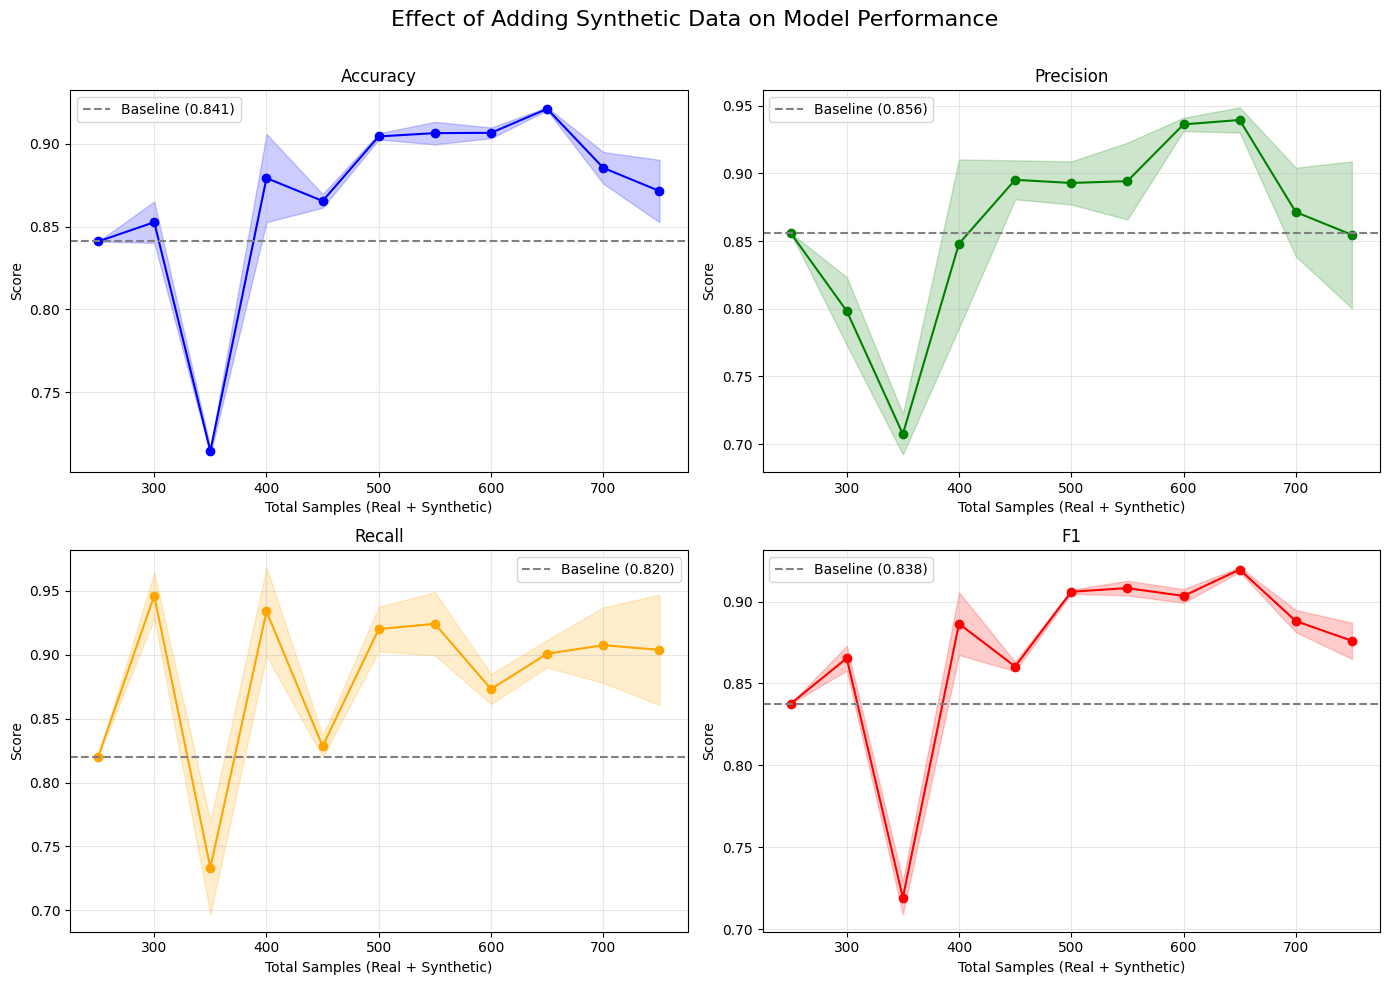

In [13]:
plt.figure(figsize=(14, 10))

# Create subplots for each metric
metrics = ['accuracy', 'precision', 'recall', 'f1']
colors = ['blue', 'green', 'orange', 'red']

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    
    # Get values
    x = mean_results['total_samples']
    y = mean_results[metric]
    yerr = std_results[metric]
    
    # Plot with error bands
    plt.plot(x, y, marker='o', color=colors[i])
    plt.fill_between(
        x, 
        np.maximum(0, y - yerr),
        np.minimum(1, y + yerr),
        color=colors[i], 
        alpha=0.2
    )
    
    # Add baseline reference line
    baseline_value = y.iloc[0]
    plt.axhline(y=baseline_value, color='gray', linestyle='--', 
                label=f'Baseline ({baseline_value:.3f})')
    
    plt.title(f'{metric.capitalize()}')
    plt.xlabel('Total Samples (Real + Synthetic)')
    plt.ylabel('Score')
    plt.grid(True, alpha=0.3)
    plt.legend()

plt.suptitle('Effect of Adding Synthetic Data on Model Performance', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

### 📈 Analyzing the Effect of Synthetic Reviews on Model Performance

We gradually added synthetic data in increments of 50 examples (balanced: 50 positive + 50 negative), up to 500.

### 🔍 Key Observations

1. **Initial Boost (Up to \~650 samples total):**

   * Adding up to 400 synthetic samples (for a total of 650) significantly improved all metrics.
   * At this point, the model reached an **F1 score of \~0.92**, nearly matching our previous benchmark trained with **1,000 real samples**.

2. **Degradation Beyond 650 Samples:**

   * As we pushed beyond 650 total samples, performance **plateaued or slightly declined**.
   * This suggests that adding too many synthetic examples can **introduce noise**, reduce diversity, or cause the model to overfit on artificial patterns.

3. **Instability with Some Sizes (e.g., 350 samples):**

   * We observed **sharp performance drops** at certain points, particularly around 350 total samples.
   * This shows that **not all synthetic examples are helpful** — some may confuse the model or misalign with the task distribution.

---

### 🎓 What This Tells Us

* Synthetic reviews from LLMs can be **incredibly powerful for data augmentation**, especially in low-resource settings.
* However, **more is not always better**: unfiltered synthetic content can dilute signal quality and degrade robustness.
* There's a need for **filtering, weighting**, or **feedback-driven generation** (e.g., sampling based on false positives/negatives) to fine-tune the balance between signal and noise.
